---
title: NRT Fire and FWI Visualizations
description: Use a FireID to create quick plots of the active fire, it's growth over time, and when available the weather surrounding the fire's origin.
author: Avery Fratto
date: July 1, 2024


## Run this notebook

You can launch this notbook using mybinder, by clicking the button below.

<a href="https://mybinder.org/v2/gh/NASA-IMPACT/veda-docs/HEAD?labpath=notebooks/tutorials/mapping-fires.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

Let's start by importing some of the necessary packages

In [222]:
# Uncomment if you need to install these. 

#!pip install OWSLib==0.28.1 --quiet
#!pip3 install contextily
#!pip install geodatasets
#!pip install matplotlib-scalebar

In [259]:
# needed imports

from owslib.ogcapi.features import Features
import geopandas as gpd
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

%matplotlib inline

import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
from geodatasets import get_path
import matplotlib.patches as mpatches 
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar

In [260]:
import matplotlib 
import cartopy.crs as ccrs
from matplotlib.pyplot import legend

## About the Data


The fire data shown is generated by the FEDs algorithm. The FEDs algorithm tracks fire movement and severity by ingesting observations from the VIIRS thermal sensors on the Suomi NPP and NOAA-20 satellites. This algorithm uses raw VIIRS observations to generate a polygon of the fire, locations of the active fire line, and estimates of fire mean Fire Radiative Power (FRP). The VIIRS sensors overpass at ~1:30 AM and PM local time, and provide estimates of fire evolution ~ every 12 hours. The data produced by this algorithm describe where fires are in space and how fires evolve through time. This CONUS-wide implementation of the FEDs algorithm is based on [Chen et al 2020’s](https://www.nature.com/articles/s41597-022-01343-0) algorithm for California.


The data produced by this algorithm is considered experimental. 

We'll now set up the API for queries and create some easy to access datetime variables. 

In [261]:
OGC_URL = "https://firenrt.delta-backend.com"

w = Features(url=OGC_URL)

We will focus on the `public.eis_fire_snapshot_fireline_nrt` collection, the `public.eis_fire_snapshot_perimeter_nrt` collection, and the `public.eis_fire_lf_perimeter_archive` collection here. 

In [262]:
perm = w.collection("public.eis_fire_snapshot_perimeter_nrt")

In [263]:
perm_q = w.collection_queryables("public.eis_fire_snapshot_perimeter_nrt")

Now that we've read in the API, we're going to focus on fires in the past week or month (depending on user needs). 

In [264]:
## Get the most recent fire perimeters, and 7 days before most recent fire perimeter
most_recent_time = max(*perm["extent"]["temporal"]["interval"])
now = dt.datetime.strptime(most_recent_time, "%Y-%m-%dT%H:%M:%S+00:00")
last_week = now - dt.timedelta(weeks=1)
last_week = dt.datetime.strftime(last_week, "%Y-%m-%dT%H:%M:%S+00:00")
last_month = now - dt.timedelta(days=50)
last_month = dt.datetime.strftime(last_month, "%Y-%m-%dT%H:%M:%S+00:00")
print("Most Recent Time =", most_recent_time)
print("Last week =", last_week)
print("Last month =", last_month)
two_months= now - dt.timedelta(days=75)
two_months = dt.datetime.strftime(two_months, "%Y-%m-%dT%H:%M:%S+00:00")

Most Recent Time = 2024-07-18T00:00:00+00:00
Last week = 2024-07-11T00:00:00+00:00
Last month = 2024-05-29T00:00:00+00:00


With that done, we can get to mapping fires!

## If you have the fire by name, we can search for it that way.

In [219]:
NameOfFire=' '

In [237]:
NameOfFire= input("What's the name of the fire?")

What's the name of the fire? little twist


In [238]:
if NameOfFire:
    perurl = 'https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/WFIGS_Interagency_Perimeters_Current/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
    polygdf = gpd.read_file(perurl)
    polygdf = polygdf.set_crs("EPSG:4326")
    polygdf['poly_IncidentName'] = polygdf['poly_IncidentName'].str.lower()
    #buffering WFIGS polygon layer by 187.5m, the "radius" of the spatial resolution of VIIRS
    polygdf = polygdf.to_crs(epsg=32633)
    polygdf['geometry'] = polygdf['geometry'].buffer(187.5)
    
    perm_results = w.collection_items(
    "public.eis_fire_snapshot_perimeter_nrt",  # name of the dataset we want
    bbox=('-125', '-65', '24', '50'),  # coordinates of bounding box
    datetime=[last_month + "/" + most_recent_time],  # date range
    limit=9999,  # max number of items returned
    )

    mydf = gpd.GeoDataFrame.from_features(perm_results["features"])
    mydf = mydf.set_crs("EPSG:4326")
    mydf = mydf.to_crs(epsg=32633)
    mydf = mydf[mydf['farea'] >= 5]
    
    poly_join_inner_df = mydf.sjoin(polygdf, how="inner")
    
    NameOfFire = NameOfFire.lower()
    
    if NameOfFire in poly_join_inner_df['poly_IncidentName'].values:
        fireid = poly_join_inner_df[poly_join_inner_df['poly_IncidentName'] == NameOfFire]
        userPlace = fireid['fireid'].values[0]
        print("fireid associated with", NameOfFire,  "is", userPlace)
        
        
    else: 
        print("The name is not present in the WFIGS dataset of current fire incidents, so we could not join a name to the fireid. Use the map below to find the fireid directly.")
    
    
    
    

    
    

fireid associated with little twist is 80464


## If you're unsure of the name, if the fireid didn't match, or if you want to double check the ID provided, we can search for the fire by location.

In [239]:
bounding_boxes = pd.read_csv("US_State_Bounding_Boxes.csv")
bounding_boxes = bounding_boxes[['NAME', 'xmin', 'ymin', 'xmax', 'ymax']]

In [240]:
state = input("What State would you like the bounding box coordinates for?")

What State would you like the bounding box coordinates for? Utah


In [265]:
state_coordinates= bounding_boxes[bounding_boxes['NAME'] == state]
state_coordinates = state_coordinates.values.tolist()
state_coordinates = list(state_coordinates)
state_coordinates = state_coordinates[0]
state_coordinates = state_coordinates[1:5]


In [266]:
new_state_coords = []
for i in state_coordinates:
    i = f'{i}'
    new_state_coords.append(i)
new_state_coords

['-114.052962', '36.997968', '-109.041058', '42.001567']

In [267]:
activePerm_results = w.collection_items(
    "public.eis_fire_snapshot_fireline_nrt",  # name of the dataset we want
    bbox=new_state_coords,  # coodrinates of bounding box
    datetime=[two_months + "/" + most_recent_time],  # date range
    limit=9999
)

In [268]:
perm_results = w.collection_items(
    "public.eis_fire_snapshot_perimeter_nrt",  # name of the dataset we want
    bbox=new_state_coords,  # coordinates of bounding box
    datetime=[two_months + "/" + most_recent_time],  # date range
    limit=9999,  # max number of items returned
)

In [269]:
df = gpd.GeoDataFrame.from_features(perm_results["features"])
df = df.set_crs("EPSG:4326")

In [270]:
activePermdf= gpd.GeoDataFrame.from_features(activePerm_results["features"])
activePermdf= activePermdf.set_crs("EPSG:4326")

In [271]:
df.explore()

Use the map above to look at the fires in the state you selected. Zoom to where you know the fire happened, and select the fire to get its fireid. 

In [287]:

userPlace = int(input('Enter fireid for the fire of interest:'))


Enter fireid for the fire of interest: 80464


Continue to plot the fire's perimeter and active fire line on a map!

In [288]:
place= df[df['fireid'] == userPlace]
activePlace = activePermdf[activePermdf['fireid'] ==userPlace]

In [289]:
from shapely.geometry.point import Point

points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

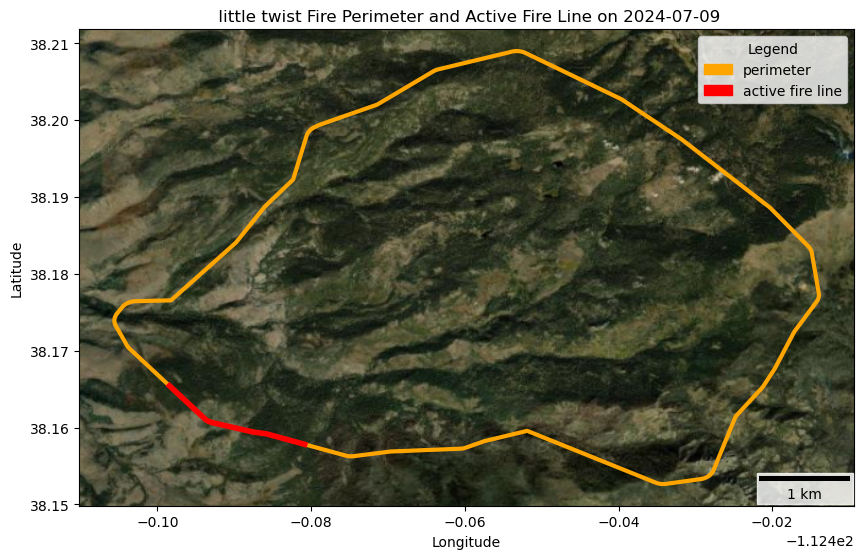

In [290]:
fig = place.plot(figsize=(10,12), facecolor = 'None', edgecolor = 'orange', linewidth=3, legend = True)
activePlace.plot( facecolor="none", ax=fig, edgecolor="red", linewidth=4, legend = True)
time = place['t']
time = str(time)
time = time.split('T')
time = time[0]
time=time.split('  ')
time=time[2]
plot_title =(f" {userPlace} Fire Perimeter and Active Fire Line on {time}")
if NameOfFire:
    plot_title=(f" {NameOfFire} Fire Perimeter and Active Fire Line on {time}")
fig.set_title(plot_title)
fig.set_xlabel("Longitude")
fig.set_ylabel("Latitude")                           
fig.legend(['active fire line'])
cx.add_basemap(fig, crs=place.crs.to_string(), source=cx.providers.Esri.WorldImagery, attribution = False)
red_patch = mpatches.Patch(color='red', label = 'active fire line')
orange_patch = mpatches.Patch(color = 'orange', label = 'perimeter')
matplotlib.pyplot.legend(handles = [orange_patch,  red_patch], title='Legend', bbox_to_anchor=(1.0,1.0))
scale1 = ScaleBar(
    dx=distance_meters,
    location="lower right",  # in relation to the whole plot
    box_alpha=0.8,
)
fig.add_artist(scale1)


If you'd like to change the basemap, here are some reliable options. 

In [291]:
#other basemap options!
ctx.providers.Esri

{'WorldStreetMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Street_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri, DeLorme, NAVTEQ, USGS, Intermap, iPC, NRCAN, Esri Japan, METI, Esri China (Hong Kong), Esri (Thailand), TomTom, 2012',
  'attribution': 'Tiles (C) Esri -- Source: Esri, DeLorme, NAVTEQ, USGS, Intermap, iPC, NRCAN, Esri Japan, METI, Esri China (Hong Kong), Esri (Thailand), TomTom, 2012',
  'name': 'Esri.WorldStreetMap'},
 'DeLorme': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'Specialty/DeLorme_World_Base_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Copyright: &copy;2012 DeLorme',
  'attribution': 'Tiles (C) Esri -- Copyright: (C)2012 DeLorme',
  'min_zoom': 1,
  'max_zoom': 11,
  'name': 'Esri.DeLorme',
  'status': 'broken'},
 'WorldTopoMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Topo_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community',
  'attribution': 'Tiles (C) Esri -- Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community',
  'name': 'Esri.WorldTopoMap'},
 'WorldImagery': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Imagery',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
  'attribution': 'Tiles (C) Esri -- Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
  'name': 'Esri.WorldImagery'},
 'WorldTerrain': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Terrain_Base',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: USGS, Esri, TANA, DeLorme, and NPS',
  'attribution': 'Tiles (C) Esri -- Source: USGS, Esri, TANA, DeLorme, and NPS',
  'max_zoom': 13,
  'name': 'Esri.WorldTerrain'},
 'WorldShadedRelief': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Shaded_Relief',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri',
  'attribution': 'Tiles (C) Esri -- Source: Esri',
  'max_zoom': 13,
  'name': 'Esri.WorldShadedRelief'},
 'WorldPhysical': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Physical_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: US National Park Service',
  'attribution': 'Tiles (C) Esri -- Source: US National Park Service',
  'max_zoom': 8,
  'name': 'Esri.WorldPhysical'},
 'OceanBasemap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'Ocean/World_Ocean_Base',
  'html_attribution': 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
  'attribution': 'Tiles (C) Esri -- Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
  'max_zoom': 13,
  'name': 'Esri.OceanBasemap'},
 'NatGeoWorldMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'NatGeo_World_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC',
  'attribution': 'Tiles (C) Esri -- National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS

## Visualize the Growth of the Fire

We may be interested in understanding how a fire evolved through time. To do this, we can work with the "Large fire" or "lf" perimeter collections. 

In [292]:

userPlace = str(userPlace)
FuserPlace = "F" + userPlace
#perimeters= perimeters[perimeters['fireid'] == FuserPlace]


In [252]:
perimeters_archive_results = w.collection_items(
    "public.eis_fire_lf_perimeter_nrt",
    bbox=new_state_coords,  # coodrinates of bounding box
    datetime=[two_months + "/" + most_recent_time],
    limit=9999

)

perimeters_archive_results
perimeters = gpd.GeoDataFrame.from_features(perimeters_archive_results["features"])
perimeters = perimeters.set_crs("epsg:4326")

In [301]:
perimeters_archive_results = w.collection_items(
    "public.eis_fire_lf_perimeter_nrt",
    bbox=new_state_coords,  # coodrinates of bounding box
    filter=f"fireid = '{FuserPlace}'",
    limit=9999

)

perimeters_archive_results
perimeters = gpd.GeoDataFrame.from_features(perimeters_archive_results["features"])
perimeters = perimeters.set_crs("epsg:4326")

In [295]:
#max_area_index = perimeters['farea'].idxmax()
#perimeters = perimeters.iloc[:max_area_index + 1]

With the fire queried, we can manipulate the time column to make sure it plots in a more inteprettable way.

In [303]:
import statistics
import datetime
from datetime import datetime
time=perimeters['t']
time = list(time)
time.sort()


In [304]:
min_time= min(time)
min_time = str(min_time)
min_time = min_time.split('T')
min_time = min_time[0]
max_time= max(time)
max_time = str(max_time)
max_time = max_time.split('T')
max_time = max_time[0]

print(min_time)
print(max_time)

2024-06-01
2024-07-12


In [305]:
from matplotlib.pyplot import legend

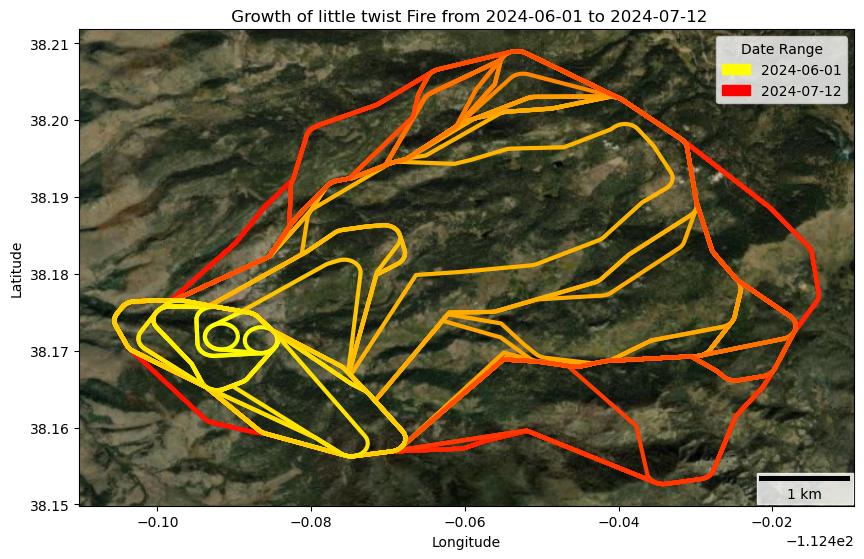

In [306]:
fig = perimeters.plot(column = 't', cmap = 'autumn_r', figsize=(10,12), linewidth=3, facecolor = 'none', legend = True)
plot_title = (f"Growth of {FuserPlace} Fire from {min_time} to {max_time}")
if NameOfFire:
    plot_title=(f" Growth of {NameOfFire} Fire from {min_time} to {max_time}")
fig.set_title(plot_title)
fig.set_xlabel("Longitude")
fig.set_ylabel("Latitude")
cx.add_basemap(fig, crs=place.crs.to_string(), source=cx.providers.Esri.WorldImagery, attribution = False)
red_patch = mpatches.Patch(color='red', label = max_time)
yellow_patch = mpatches.Patch(color = 'yellow', label = min_time)
matplotlib.pyplot.legend(handles = [yellow_patch,  red_patch], title='Date Range', bbox_to_anchor=(1.0,1.0))
scale1 = ScaleBar(
    dx=distance_meters,
    location="lower right",  # in relation to the whole plot
    box_alpha=0.8,
)
fig.add_artist(scale1)

If it seems like the mapping of the fire over time is sparse, you may want to change the datetime parameter in your query to extend further back to ensure you get the full history of the fire. To do this, change the last_month variable to two_months. 

### Now let's make a GIF of this growth over time!

In [134]:
# Filter out rows with None or empty geometries
perimeters = perimeters[perimeters['geometry'].notna() & ~perimeters['geometry'].is_empty]
perimeters = perimeters[perimeters['flinelen'] > 0]

# Convert 't' column to datetime for easier handling
perimeters['t'] = pd.to_datetime(perimeters['t'])

# Sort the data by date
perimeters = perimeters.sort_values(by='t')

In [135]:
## This function is only needed if the code below returns the error that the nodes aren't connecting
## Uncomment to round gemoetry to the 4th decimal place. 


#from shapely.geometry import shape, mapping
#def around(geom,p):
    #geojson = mapping(geom)
    #geojson['coordinates'] = np.round(np.array(geojson['coordinates']),p)
    #return  shape(geojson)
#perimeters.geometry= perimeters.geometry.apply(lambda x: around(x,4))

In [136]:
import os

In [137]:
# Initialize cumulative perimeter
cumulative_perimeter = gpd.GeoDataFrame(geometry=[], crs=perimeters.crs)

# Prepare intermediate data directory
intermediate_dir = 'intermediate_clipped_data'
if not os.path.exists(intermediate_dir):
    os.makedirs(intermediate_dir)

# Preprocess each perimeter
dates = perimeters['t'].unique()
for i, date in enumerate(dates):
    # Filter for current date's data
    current_perimeters = perimeters[perimeters['t'] == date]

    # Clip current perimeters with cumulative perimeter
    if not cumulative_perimeter.empty:
        current_perimeters = gpd.overlay(current_perimeters, cumulative_perimeter, how='difference', keep_geom_type=False)

    # Save the clipped current perimeters
    current_perimeters.to_file(os.path.join(intermediate_dir, f'clipped_perimeters_{i}.geojson'), driver='GeoJSON')

    # Update cumulative perimeter
    cumulative_perimeter = gpd.GeoDataFrame(pd.concat([cumulative_perimeter, current_perimeters], ignore_index=True))


In [138]:
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

In [139]:
# Function to add black outline to text
def draw_text_with_outline(ax, text, x, y, fontsize=14, fontweight='bold', fontcolor='white', outlinecolor='black'):
    from matplotlib.patheffects import withStroke
    ax.text(x, y, text, verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=fontsize, fontweight=fontweight, color=fontcolor,
            path_effects=[withStroke(linewidth=3, foreground=outlinecolor)])

# Color interpolation function for creating a gradient of darker colors
def generate_darker_colors(base_color, num_colors):
    base_rgb = np.array(mcolors.hex2color(base_color))
    colors = []
    for i in range(num_colors):
        factor = (i + 1) / num_colors
        darker_rgb = base_rgb * (1 - factor)
        colors.append(mcolors.to_hex(darker_rgb))
    return colors

# Generate a list of darker colors for each time step
base_color = '#f77f00'
num_dates = len(perimeters['t'].unique())
darker_colors = generate_darker_colors(base_color, num_dates)[::-1]

# Prepare output directory for frames
output_dir = 'frames_new'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the style for the current growth layer
growth_style = {
    'edgecolor': '#f94144',
    'facecolor': base_color,
    'alpha': 0.7,
    'linewidth': 2
}

# Calculate the overall bounding box with a buffer
total_bounds = perimeters.total_bounds

#### IMPORTANT: Adjust this buffer value as needed, to give extra breathing room around the edge of the map ####
buffer = 0.1

x_min, y_min, x_max, y_max = total_bounds[0] - buffer, total_bounds[1] - buffer, total_bounds[2] + buffer, total_bounds[3] + buffer

# Create frames
dates = perimeters['t'].unique()
for i, date in enumerate(dates):
    fig, ax = plt.subplots(1, 1, figsize=(14, 14))  # Increase figure size for better visibility

    # Load preprocessed clipped perimeters for the current date
    current_perimeters = gpd.read_file(os.path.join(intermediate_dir, f'clipped_perimeters_{i}.geojson'))

    # Plot all previous perimeters with unique darker colors
    for j in range(i-1, -1, -1):  # Iterate in reverse order to plot oldest on top
        past_perimeters = gpd.read_file(os.path.join(intermediate_dir, f'clipped_perimeters_{j}.geojson'))
        past_color = darker_colors[j]
        past_style = {
            'edgecolor': past_color,
            'facecolor': past_color,
            'alpha': 0.7,
            'linewidth': 1
        }
        past_perimeters.plot(ax=ax, **past_style, aspect=1)

    # Plot the current growth layer
    current_perimeters.plot(ax=ax, **growth_style, aspect=1)

    # Set fixed extent to ensure basemap remains consistent
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Add OSM HOT basemap
    ctx.add_basemap(ax, crs=perimeters.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution="", zoom=12)

    # Remove axis borders and labels
    ax.set_aspect('equal')
    ax.axis('off')

    # Add formatted date label in the top right corner
    formatted_date = date.strftime('%B %d, %Y')
    draw_text_with_outline(ax, f"{formatted_date}", 0.95, 0.95)

    # Add an inset axis for the overview map
    inset_ax = inset_axes(ax, width="25%", height="25%", loc='lower left', borderpad=2)

    # Plot the overview map in the inset axis
    inset_x_min = total_bounds[0] - 5
    inset_y_min = total_bounds[1] - 5
    inset_x_max = total_bounds[2] + 5
    inset_y_max = total_bounds[3] + 5
    inset_ax.set_xlim(inset_x_min, inset_x_max)
    inset_ax.set_ylim(inset_y_min, inset_y_max)
    ctx.add_basemap(inset_ax, crs=perimeters.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution="", zoom = 4)
    inset_ax.set_aspect('equal')
    inset_ax.axis('off')

    # Draw a red box around the affected area
    inset_ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 edgecolor='red', facecolor='none', linewidth=2))

    # Add a border around the inset
    inset_border = Rectangle((0, 0), 1, 1, transform=inset_ax.transAxes,
                             facecolor='none', edgecolor='black', linewidth=2, clip_on=False)
    inset_ax.add_patch(inset_border)

    # Save frame
    frame_path = os.path.join(output_dir, f'frame_{i:03d}.png')
    plt.savefig(frame_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

print(f"Static images saved in directory: {output_dir}")

Static images saved in directory: frames_new


In [140]:
# more installations needed
#!pip install imageio
#!pip install imageio[ffmpeg]
#!pip install imageio[pyav]

In [141]:
import imageio.v2 as imageio

In [142]:
# Prepare output MP4 file
output_mp4 = 'fire_animation.mp4'

# Collect all frame file paths
frames = [os.path.join(output_dir, f'frame_{i:03d}.png') for i in range(len(dates))]

# Create animated MP4
with imageio.get_writer(output_mp4, mode='I', fps=1) as writer:  #Adjust FPS here
    for frame_path in frames:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"Animated MP4 saved as: {output_mp4}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3255, 3004) to (3264, 3008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x61ec6c0] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x6205c00] Warning: data is not aligned! This can lead to a speed loss


Animated MP4 saved as: fire_animation.mp4


To access your GIF, download the fire_animation.mp4 that's populated in your directory. Name it as the fireid or fire name for organization purposes. You can them open the download. 

### Fire Weather 

Here we can look at how the weather during the fire compares to historical averages. 

NOTE: This is experimental. Not all fires have weather stations within a realtively close distance, so data may not be accurate to actual conditons during the fire. 

In [205]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
import sys
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from bs4 import BeautifulSoup
import requests
sys.path.insert(0, '/projects/shared-buckets/afratto/fwiVis/base-fwi-vis')
import fwiVis.fwiVis as fv

In [206]:

files = fv.listFD("https://portal.nccs.nasa.gov/datashare/GlobalFWI/StnFWI/19900101.NRT/FWI", "csv") # This will update through time. Not nessisary now because focus on 2019

In [207]:
st_id_map = pd.read_csv('https://portal.nccs.nasa.gov/datashare/GlobalFWI/StnFWI/19900101.NRT/isd-history.csv')


In [208]:
def st_avail(files, st_id_map, inter_type = "linear.HourlyFWIFromHourlyInterpContinuous", path_s3 = "veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI", https_path = False):

    print("Searching for availible stations at" + path_s3)

    if(https_path):
        file_inter = []
        for file in listFD(path_s3, "csv"):
            file_inter.append(file)
    else:
        file_inter = []
        for path in files:
            if inter_type in path:
                file_inter.append(path)
    df = []
    for i in file_inter:
        pt_1 = re.sub(path_s3, "", i)
        #pt_2 = re.sub(".spline.DailyFWIfromHourlyInterp.csv","",  pt_1)
        pt_2 = re.sub(("." + inter_type + ".csv"), "", pt_1)
        pt_3 = pt_2.split("/FWI/")
        pt_4 = pt_3[1]
        pt_5 = pt_4.split("-")
        usaf = re.sub(r'[^0-9]', '',pt_5[0]) ## Sometimes ID had extra characters? 
        wban = re.sub(r'[^0-9]', '',pt_5[1]) 
        
        st = st_id_map.loc[(st_id_map.USAF == usaf) | (st_id_map.WBAN == wban)]
       # print(st)
        if(st.empty):
            print("Empty Dataframe")
            break
        
        lat = st.LAT.iloc[0]
        lon = st.LON.iloc[0]

        df.append({
            "File_path": i,
            "Lat": lat,  
            "Lon": lon,
            "USAF": usaf,
            "WBAN": wban
        })
   
    return(pd.DataFrame(df))

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]



In [209]:
stations = st_avail(files, st_id_map = st_id_map)

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI


In [210]:
st_dict = stations[['Lat', 'Lon']].to_dict('records')


In [211]:
## Load up that fire 
fireID = userPlace
gdf = fv.load_large_fire(fireID, year = "2024", path_region = "CONUS_NRT_DPS")

/projects/shared-buckets/afratto/fwiVis/base-fwi-vis/fwiVis/fwiVis.py:444: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/shared-buckets/afratto/fwiVis/base-fwi-vis/fwiVis/fwiVis.py:445: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [212]:

foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element

## Look for closest station
st_cls = fv.closest(st_dict, foi)
st_cls

The closest station is 604.8504740145847 km away.


{'Lat': 35.883, 'Lon': -106.283}

In [213]:
def get_st(lat, lon, stations, flag_bad = False):
  
    st = stations.loc[(stations.Lat == lat) & (stations.Lon == lon)]
    #dat = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220907.hrlyInterp/FWI/727970-94240.spline.DailyFWIfromHourlyInterp.csv")
    dat = pd.read_csv((st.File_path.iloc[0]), index_col = False)
    #"s3://" + 
    dat = date_convert(dat)
    
    if flag_bad:
        mask = dat['OBSMINUTEDIFF_TEMP'].loc[dat.OBSMINUTEDIFF_TEMP > 20]  ## Kluge. Basically, use this as a flag. 
        dat.iloc[mask.index, 4:-4 ] = np.nan
    
    return(dat)

def date_convert(dat_time):
  
    dat_time.HH = dat_time.HH.astype('int') # Drop #.0
    dat_time.HH = dat_time.HH.astype('str')
    dat_time['HH_format'] = dat_time.HH.apply(hour_fix)
    dat_time['time'] = pd.to_datetime(dat_time['YYYY'].astype(str) +"-"+  dat_time['MM'].astype("str") +"-"+  dat_time['DD'].astype("str") + " " + dat_time['HH_format'].astype('str'), format='%Y-%m-%d %H')

    return(dat_time)


def hour_fix (hr):

    small_hr = ["0","1","2","3","4","5","6","7","8","9"]
    append = ""
    
    if (hr in small_hr):
        append = "0"
    hr = append + hr
    
    return(hr)

In [214]:
## Get station Data
st = get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations, flag_bad=False)


In [215]:
import datetime

In [216]:
def plot_st_history(st_id_map, st_dict, stations, title = None, path = None, lat_lon = None, USAF_WBAN = None, seasons = [5, 6, 7], year = None, plot_var = "FWI", clim_normal_min = datetime.datetime(1991, 1, 1), 
    clim_normal_max = datetime.datetime(2020, 12, 31)):
    '''
    Plots weather station data against historic means. Stations can be plotted form a file path, an USAF_WBAN id, or a lat and lon combination. If no station is at the exact lat lon, the function will search for the closest one. 
    
    INPUTS:
        st_dict (dict): A  dictionary with "Lat" and "Lon" entries for each weather station. A dictionary of the output from st_avail.
        stations (DataFrame): a dataframe as outputted by st_avail. A dataframe with columns for station lat, lon, and ID.
        st_id_map (DataFrame): a dataframe that connects Station IDs to full names and locations. 
        title (str):  An optional title for the plot. Optional. "None" is default. If "None", title will be the WMO ID of the station. 
        path (str):  Path to staion data csv. Optional. Default to "None". 
        lat_lon (list): A list of the form [lat_float, lon_float]. Optional. If lat and lon are not exact matches, function will search for closest station. 
        USAF_WBAN (list): List of the form [USAF, WBAN]. Optional. 
        seasons (list): List with single-digit representations of months to include in averaging across years. Default [5, 6, 7] or May, June and July. 
        year (str): The year of station data to compare to historic means. Defaults to "None", where the most recent data will be compared.
        plot_var (str): Variable to plot. Defaults to "FWI". 
        clim_normal_min (datetime): minimum period for climate normal. Defaults to January 1, 1991. If station data doesn not extend as far back as minimum, normal will be on min of station data and will throw a warning. 
        clim_normal_max (datetime): Maximum period for climate normal. Defaults to December 31st, 2020. If station data doesn not extend into maximum, normal will be on max of station data and will throw a warning. 
    '''
    
    if(all([path == None, lat_lon == None, USAF_WBAN == None])):
        print("Error: No specifying information provided. Please include a path to station, a lat-lon, or a USAF_WBAN id. ")
    if(path == None):
        if( not USAF_WBAN == None ):
            st = stations.loc[(stations.USAF == USAF_WBAN[0]) & (stations.WBAN == USAF_WBAN[1])]
            path = "s3://" + st.File_path.iloc[0]
        else:
            st = stations.loc[(stations.Lat == lat_lon[0]) & (stations.Lon== lat_lon[1])]
            if(len(st) == 0):
                st_cls = fv.closest(st_dict, pd.DataFrame(data = {"Lat" :[lat_lon[0]], "Lon" :  [lat_lon[1]]}))
                st = stations.loc[(stations.Lat == st_cls["Lat"]) & (stations.Lon == st_cls["Lon"])]
                
            path = st.File_path.iloc[0]
    
    if(title == None):
        split = re.split(pattern = "/", string = path)
        split = split[-1]
        WMO_id = re.sub(pattern = "\..*", repl = "",  string = split)
        extra = ""
        if("s3://" in path):  
            id_split = re.split(pattern = "-", string = WMO_id)
            labs = st_id_map[(st_id_map.USAF == str(id_split[0])) & (st_id_map.WBAN == str(id_split[1]))]
            extra = str(*labs['STATION NAME'])  + str(*labs['CTRY'])+ ", " + str(*labs['STATE'])
        title = "Weather Station" + extra +  "WMO ID (" + WMO_id + ")"


    st = pd.read_csv(path)
    if(not np.any(st.columns.isin(["HH"]))):
         st['HH'] = '12'
    st.YYYY = st.YYYY.astype("int")
    st.MM = st.MM.astype("int")
    st.DD = st.DD.astype("int")
    st.HH = st.HH.astype("int")
    st = date_convert(st)
    
    max_season = max(seasons)
    if(max_season <= 9):
        max_season = "0" + str(max_season)
    min_season = min(seasons)
    if(min_season <= 9):
        min_season = "0" + str(min_season)
    min_season = str(min_season)
    max_season = str(max_season)
    
    if(year == None):
        print("Plotting most-recent year and seasons:" + str(seasons))
        #ctime = datetime.datetime.now()
        #year = str(ctime.year)
        year = str(max(st.time.dt.year))
    else:
        year = year
    
    max_day = year + "-" + max_season + "-28 23:00:00" ## Hack
    min_day = year + "-" + min_season + "-01 00:00:00"
        

    st['isinseason'] = st.MM.isin(seasons) # Is May, June or July? 
    mj = st[st['isinseason'] == True]
    mj = mj.set_index("time")
    

    # Try to use 1991-2020, or user supplied range as climate normal. If not possible, get as close as you can.     
    if((min(st.time) > clim_normal_min) |  (max(st.time) < clim_normal_max)):
        print("WARNING: Station record does not cover assumed climate normal (1991-2020).")
        print("Using range " + str(max(clim_normal_min, min(st.time))) + ":" + str(min(clim_normal_max, max(st.time))) + " instead.")
        mj = mj[mj.index > max(clim_normal_min, min(st.time))]
        mj = mj[mj.index < min(clim_normal_max, max(st.time))]
    mj = mj[mj.index.strftime('%m-%d') != '02-29'] # Drop leap-day becuase it's only sampled once every 4 years
    mean_quant = mj.groupby([mj.index.day.astype("int"), mj.index.month.astype("int")]).mean(numeric_only=True)


    dates = ( year + "-" + mean_quant.index.get_level_values(level=1).astype("str") + "-" + mean_quant.index.get_level_values(level=0).astype("str"))

    mean_quant["dates"] = pd.to_datetime(dates)
    mean_quant = mean_quant.sort_values(by = "dates")
    mean_quant.set_index("dates", inplace = True)


    upper = mj.select_dtypes(include='number').groupby([mj.index.day, mj.index.month]).quantile((1-0.025), numeric_only=True)
    upper["dates"] = pd.to_datetime(dates)
    upper = upper.sort_values(by = "dates")
    upper.set_index("dates", inplace = True)

    lower = mj.select_dtypes(include='number').groupby([mj.index.day, mj.index.month]).quantile((0.025),  numeric_only=True)
    lower["dates"] = pd.to_datetime(dates)
    lower = lower.sort_values(by = "dates")
    lower.set_index("dates", inplace = True)


    mid_lower = mj.select_dtypes(include='number').groupby([mj.index.day, mj.index.month]).quantile((0.25),  numeric_only=True)
    mid_lower["dates"] = pd.to_datetime(dates)
    mid_lower = mid_lower.sort_values(by = "dates")
    mid_lower.set_index("dates", inplace = True)


    mid_upper = mj.select_dtypes(include='number').groupby([mj.index.day, mj.index.month]).quantile((0.75),  numeric_only=True)
    mid_upper["dates"] = pd.to_datetime(dates)
    mid_upper = mid_upper.sort_values(by = "dates")
    mid_upper.set_index("dates", inplace = True)
    
    st = st.sort_values(by = ["time"])
    try:
        upper[plot_var].rolling(5).mean()
    except:
        print("print_var is not present in this weather station. Columns are: " + str(st.columns))
        return(None)
    
    daily_vars = ["DC", "BUI", "DMC", "PREC_MM"] # Vars that are daily even with hourly station data
    
    fig, ax = plt.subplots()
    ax.fill_between(upper.index, upper[plot_var].rolling(5).mean(), lower[plot_var].rolling(5).mean(), 
                    facecolor='grey', 
                    alpha=0.2,
                    label= "95th Percentile")
    ax.fill_between(mid_upper.index, mid_upper[plot_var].rolling(5).mean(), mid_lower[plot_var].rolling(5).mean(), 
                    facecolor='grey', 
                    alpha=0.4,
                    label= "25th Percentile")
    ax.plot(mean_quant.index, mean_quant[plot_var].rolling(5).mean(), 
            color = "black",
            label= "Historic Mean Per Day")
    if(plot_var in daily_vars):
        tmp = st.dropna()
        ax.plot(tmp[(tmp.time >= min_day) & (tmp.time <= max_day)].time.astype('datetime64[ns]'), tmp[(tmp.time >= min_day) & (tmp.time <= max_day)][plot_var], color = 'blue', label='current')
    else:
        ax.plot(st[(st.time >= min_day) & (st.time <= max_day)].time.astype('datetime64[ns]'), st[(st.time >= min_day) & (st.time <= max_day)][plot_var], color='blue', label='Current')
   
    ax.set_ylabel(plot_var)
    ax.set_title(title)
    ax.legend()
    fig.autofmt_xdate()
    #return(st)


In [217]:
coords = st_cls
# Create a list with latitude and longitude as numeric values
coords = [coords['Lat'], coords['Lon']]

Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.
Plotting most-recent year and seasons:[5, 6, 7]
Using range 2005-12-31 17:00:00:2020-12-31 00:00:00 instead.


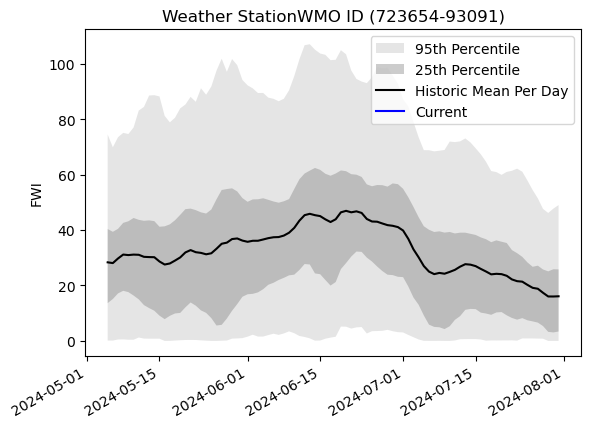

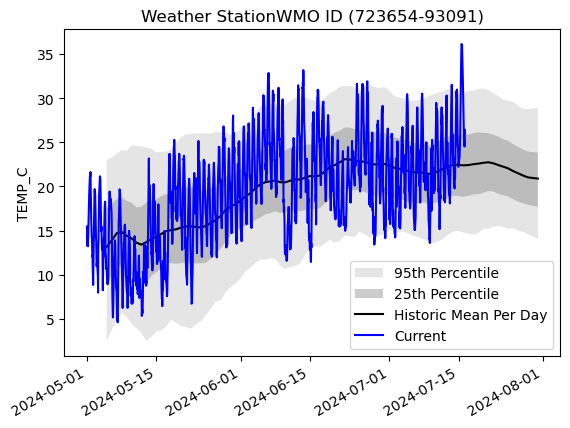

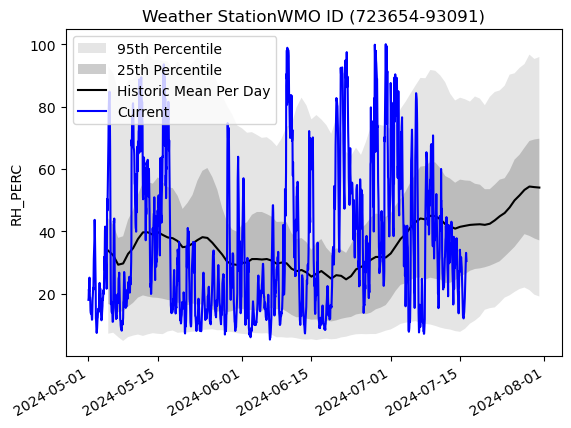

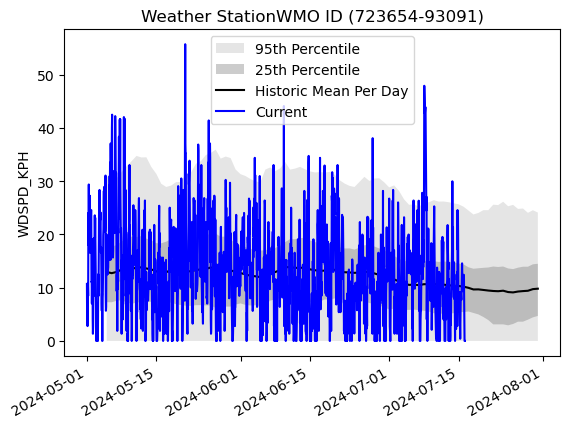

In [218]:
vars = ['FWI', 'TEMP_C', 'RH_PERC', 'WDSPD_KPH']
for var in vars: 
    plot_st_history(st_id_map, st_dict, stations, lat_lon=coords,  plot_var = var)